In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [2]:
import json

with open('topic_testing/podcast_28.txt', 'rb') as f:
    request = json.load(f)

In [3]:
import sys 
sys.path.append("../../../ai-engine/pkg/")
import networkx as nx
import community
import math
import logging
from log.logger import setup_server_logger
logger = logging.getLogger()
setup_server_logger(debug=False)

ModuleNotFoundError: No module named 'pythonjsonlogger'

In [4]:
from numpy import dot
from numpy.linalg import norm
from boto3 import client as boto3_client
import json
from botocore.client import Config
import numpy as np
from copy import deepcopy

config = Config(connect_timeout=240, read_timeout=240, retries={'max_attempts': 0}, )
lambda_client = boto3_client('lambda', config=config)

def preprocess_text(text, segid):
    mod_texts_unfiltered = tp.preprocess(text, stop_words=False, remove_punct=False)
    mod_texts = []

    for index, sent in enumerate(mod_texts_unfiltered):
        if len(sent.split(' ')) > 250:
            length = len(sent.split(' '))
            split1 = ' '.join([i for i in sent.split(' ')[:round(length / 2)]])
            split2 = ' '.join([i for i in sent.split(' ')[round(length / 2):]])
            mod_texts.append(split1)
            mod_texts.append(split2)
            continue

        if len(sent.split(' ')) <= 6:
            continue

        mod_texts.append(sent)
    return (mod_texts, segid)


def cosine(vec1, vec2):
    return dot(vec1, vec2) / (norm(vec1) * norm(vec2))

def get_feature_vector(input_list, lambda_function):
 # logger.info("computing feature vector", extra={"msg": "getting feature vector from mind service"})
    batches_count = 300
    feature_vector = []
    count = math.ceil(len(input_list)/batches_count)
    #logger.info("computing in batches", extra={"batches count": count, "number of sentences": len(input_list)})
    for itr in range(count):
        extra_input = deepcopy(input_list[itr*batches_count:(itr+1)*batches_count])
        mind_input = json.dumps({"text": extra_input})
        mind_input = json.dumps({"body": mind_input})
        #logger.info("getting feature vector from mind service", extra={"iteration count:": itr})
        invoke_response = lambda_client.invoke(FunctionName=lambda_function, InvocationType='RequestResponse', Payload=mind_input)
        #logger.info("Request Sent", extra={"iteration count": itr})
        # logger.info("computing feature vector", extra={"msg": "Request Sent"})
        out_json = invoke_response['Payload'].read().decode('utf8').replace("'", '"')
        #print ("Recieved Response. Checking if it's valid.")
        data = json.loads(json.loads(out_json)['body'])
        #print ("Valid Response from mind service.")
        response = json.loads(out_json)['statusCode']

        if response == 200:
            feature_vector.extend(data['sent_feats'][0])
            #logger.info("Response Recieved")

            # logger.info("computing feature vector", extra={"msg": "Response Recieved"})
        #else:
            #logger.error("Invalid response from  mind service")
            # logger.error("computing feature vector", extra={"msg": "Invalid response from  mind service"})
    return feature_vector

def compute_feature_vector_gpt(sentences, lambda_function):
        graph_list = {}
        input_list = []
        fv = {}
        index = 0
        for segment in sentences:
            for sent in segment:
                if sent != '':
                    input_list.append(sent)
                    
        transcript_score = get_feature_vector(input_list, lambda_function)
        for segment in sentences:
            for sent in segment:
                if sent != '':
                    graph_list[index] = sent
                    fv[index] = transcript_score[index]
                    index += 1
        assert(len(input_list)==len(fv.keys()))
        return fv, graph_list
    

def compute_feature_vector_gpt_para(sentences, lambda_function):
        graph_list = {}
        input_list = []
        fv = {}
        index = 0
        transcript_score = []
        for index, segment in enumerate(sentences):
            input_list = []
            for sent in segment:
                if sent != '':
                    input_list.append(sent)
            if input_list!=[]:        
                transcript_score=get_feature_vector(input_list, lambda_function)
                fv[index] = np.mean(transcript_score, axis=0)
                graph_list[index] = input_list
        print (len(fv.keys()))
        #assert(len(input_list)==len(fv.keys()))
        return fv, graph_list
    

In [10]:
import sys
sys.path.append("../../../ai-engine/pkg/")
import text_preprocessing.preprocess as tp
seg_list = []
for seg in request['body']["segments"]:
    seg_list.append(seg)

In [12]:
seg_list

[{'id': 'a0349078dbc746199b273b5a3b3e8f51',
  'originalText': "Indeed everyone they share back again with another video. Now in this video we will talk about what is a pi or also known as application programming interface. Now, this is a very common term very useful term. But there is a problem with our society or our computer Society be give 0f2, whether people understand that subject or not. We just want it to be technically correct. So if you look up for the API definition on any platform Wikipedia blog, they are technically correct. That's one part when they are not so much understandable. So in this video we are going to make sure that you understand and API what else API and after watching this video you never ever watch any video on API or blog because you will be understanding each and every bit of API, so let's get started.Let's talk about what is a pi now. Go ahead open up your favorite search engine and try to look up for what is API? Let me help you and try to read what is 

In [13]:
sent_list = []
segments = list(map(lambda x: preprocess_text(x['originalText'], x['id']), seg_list))
segments_text = []
sent_to_id = {}
for i, j in segments:
    segments_text.append(i)
    for sent in i:
        sent_to_id[sent] = j

In [14]:
#lambda_function = "mind-" + request["body"]["mindId"].lower()
lambda_function = "mind-" + "01DAAQY88QZB19JQZ5PRJFR76Y".lower()
fv, graph_list = compute_feature_vector_gpt(segments_text, lambda_function)

In [15]:
def construct_graph(fv, graph_list):
        meeting_graph = nx.Graph()
        yetto_prune = []
        c_weight = 0
        for nodea in graph_list.keys():
            for nodeb in graph_list.keys():
                if nodeb > nodea:
                    c_weight = cosine(fv[nodea], fv[nodeb])
                    meeting_graph.add_edge(nodea, nodeb, weight=c_weight)
                    yetto_prune.append((nodea, nodeb, c_weight))
        X = nx.adjacency_matrix(meeting_graph).toarray()
        for i in range(len(X)):
            X[i][i]=X[i].mean() 
        norm_mat = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        
        meeting_graph = nx.from_numpy_array(norm_mat)
        meeting_graph.remove_edges_from(list(map(lambda x: (x,x), range(meeting_graph.number_of_nodes()))))
        for i,(nodea,nodeb,score) in enumerate(yetto_prune):
            yetto_prune[i] = (nodea,nodeb,norm_mat[nodea,nodeb])
        return meeting_graph, yetto_prune

def prune_edges_outlier(meeting_graph, graph_list, yetto_prune, v):
    meeting_graph_pruned = nx.Graph()
    weights = []
    for nodea, nodeb, weight in meeting_graph.edges.data():
        meeting_graph_pruned.add_nodes_from([nodea, nodeb])
        weights.append(weight["weight"])

    # q1 = np.percentile(weights, 25)
    # iqr = np.subtract(*np.percentile(weights, [75, 25]))
    # outlier = q1 - 1.5 * iqr
    q3 = np.percentile(weights, v)
    # logger.info("Outlier Score", extra={"outlier threshold is : ": outlier})
    # logger.info("Outlier Score", extra={"outlier threshold is : ": q3})
    removed = 0
    total = 0
    for indexa, indexb, c_score in meeting_graph.edges.data():
        total+=1
        if c_score["weight"]>=q3:
            removed+=1
            meeting_graph_pruned.add_edge(indexa, indexb, weight=c_score["weight"])
    #print(total-removed, removed)
    return meeting_graph_pruned


def compute_louvian_community(meeting_graph_pruned):
    # community_set = community.best_partition(meeting_graph_pruned)
    community_set = community.best_partition(meeting_graph_pruned)
    modularity_score = community.modularity(community_set, meeting_graph_pruned)
    print ("modularity score: ", modularity_score)
    community_set_sorted = sorted(community_set.items(), key=lambda kv: kv[1], reverse=False)
    return community_set_sorted


In [16]:
from copy import deepcopy
def h_communities(fv, graph_list, v, h_flag):
    meeting_graph, yetto_prune = construct_graph(fv, graph_list)
    original_graph = deepcopy(meeting_graph)
    meeting_graph_pruned = prune_edges_outlier(meeting_graph, graph_list, yetto_prune, v)
    community_set_sorted = compute_louvian_community(meeting_graph_pruned)
    clusters = []
    temp = []
    prev_com = 0
    for index,(word,cluster) in enumerate(community_set_sorted):
        if prev_com==cluster:
            temp.append(word)
            if index==len(community_set_sorted)-1:
                clusters.append(temp)
        else:
            clusters.append(temp)
            temp = []
            prev_com = cluster
            temp.append(word)
    if (h_flag):
        community_set_collection = []
        old_cluster = []
        # print (clusters)
        for cluster in clusters:
            if len(cluster) >= 2:
                graph_list_pruned = deepcopy(graph_list)
                for k in graph_list.keys():
                    if k not in cluster:
                        del graph_list_pruned[k]

                meeting_graph, yetto_prune = construct_graph(fv, graph_list_pruned)
                meeting_graph_pruned = prune_edges_outlier(meeting_graph, graph_list_pruned, yetto_prune, v)
                community_set = community.best_partition(meeting_graph_pruned)
                community_set_sorted = sorted(community_set.items(), key=lambda kv: kv[1], reverse=False)
                #print (community_set_sorted)
                i = 0
                prev_cluster = 9999999999999999
                for (sent, cls) in community_set_sorted:
                    if cls not in old_cluster:
                        community_set_collection.append((sent, cls))
                        old_cluster.append(cls)
                        prev_cluster = cls
                        i = cls
                    else:
                        if cls == prev_cluster:
                            community_set_collection.append((sent, i))
                            continue
                        while i in old_cluster:
                            i += 1
                        prev_cluster = cls
                        community_set_collection.append((sent, i))
                        old_cluster.append(i)
                for (sent, cls) in community_set_sorted:
                    old_cluster.append(cls)
            else:
                i = 0
                while i in old_cluster:
                    i += 1
                community_set_collection.append((cluster[0], i))
                old_cluster.append(i)
            # print(community_set_collection)
        result = []
        temp = []
        prev = 0
        for sent, cls in community_set_collection:
            if prev != cls:
                result.append(temp)
                temp = []
                #print ("cluster -=======> ", cls)
                prev = cls
            else:
                temp.append(graph_list[sent])
            #print (graph_list[sent])
        community_set_collection = sorted(community_set_collection, key = lambda x: x[1], reverse=False)

    else:
        community_set_collection = deepcopy(community_set_sorted)
        result = []
        temp = []
        prev = 0
        for sent, cls in community_set_collection:
            if prev != cls:
                result.append(temp)
                temp = []
                #print ("cluster -=======> ", cls)
                prev = cls
            else:
                temp.append(graph_list[sent])
            #print (graph_list[sent])
        result.append(temp)
        community_set_collection = sorted(community_set_collection, key = lambda x: x[1], reverse=False)
    return community_set_collection, meeting_graph_pruned

In [17]:
# current = 0
# segtocls = {}
# print ("--------------cluster " + str(0) + "------------ \n ")
# for word, cluster in community_set_collection:
#     segtocls[word] = cluster
#     if cluster!=current:
#         print ("--------------cluster " + str(cluster) + "------------ \n ")
#         print (graph_list[word])
#         current=cluster
#     else:
#         print (graph_list[word])

In [18]:
def get_clusters(community_set_sorted):
    clusters = []
    temp = []
    prev_com = 0
    for index,(word,cluster) in enumerate(community_set_sorted):
        if prev_com==cluster:
            temp.append(word)
            #print (temp)
            if index==len(community_set_sorted)-1:
                clusters.append(temp)
        else:
            clusters.append(temp)
            temp = []
            prev_com = cluster
            temp.append(word)
    return (clusters)

In [19]:
# from collections import Counter
# Counter(validation_list[0]).most_common()[0][1]/len(validation_list[0])
# accuracy = []
# for val in validation_list:
#     accuracy.append(Counter(val).most_common()[0][1]/ len(val) * 100)
# import statistics as st
# print (st.mean(accuracy))

In [20]:
from collections import Counter
import statistics as st

# validate
def validate(clusters):
    validation_list = []

    for cluster in clusters:
        temp_vl = []
        for sent in cluster:
            temp_vl.append(sent_to_id[graph_list[sent]])
        validation_list.append(temp_vl)
    
    common = { }
    accuracy = []
    total_count = {}
    for val in validation_list:
        for tag in val:
            if tag in total_count.keys():
                total_count[tag] +=1
            else:
                total_count[tag] = 1
    
    for val in validation_list:
        if Counter(val).most_common()[0][0] in common.keys():
            if Counter(val).most_common()[0][1] > common[Counter(val).most_common()[0][0]]:
                common[Counter(val).most_common()[0][0]] = Counter(val).most_common()[0][1]
            else:
                continue
        else:
            common[Counter(val).most_common()[0][0]] = Counter(val).most_common()[0][1]
    
    for tag in range(0,4):
        if tag in common.keys():
            accuracy.append(common[tag]/total_count[tag])
        else:
            accuracy.append(0)
    return st.mean(accuracy)*100
# print ("accuracy is: ", st.mean(accuracy)*100)

In [343]:
for v in range(0, 100, 5):
    community_set_collection, meeting_graph_pruned = h_communities(fv, graph_list, v, h_flag=0)
    clusters = get_clusters(community_set_collection)
    accuracy = validate(clusters)
    print (v, accuracy)

modularity score:  0.07075096430930686
0 97.5
modularity score:  0.07178293503006968
5 97.5
modularity score:  0.07425615013479206
10 97.5
modularity score:  0.07794901892776597
15 97.5
modularity score:  0.08602399415285027
20 97.5
modularity score:  0.09734891179304345
25 97.5
modularity score:  0.11372136107292041
30 97.5
modularity score:  0.13149352340763887
35 97.5
modularity score:  0.15325707374452557
40 92.5
modularity score:  0.17898521717953658
45 92.5
modularity score:  0.20625294546620807
50 97.5
modularity score:  0.23431481527315862
55 97.5
modularity score:  0.27739368732339714
60 97.5
modularity score:  0.2980649626708135
65 97.5
modularity score:  0.3620434999901929
70 97.5
modularity score:  0.426492278868669
75 97.5
modularity score:  0.4942975508655702
80 97.5
modularity score:  0.6105755614384234
85 97.5
modularity score:  0.6606711832967314
90 87.5
modularity score:  0.7637605397374723
95 67.5


In [344]:
community_set_collection, meeting_graph_pruned = h_communities(fv, graph_list, v=0, h_flag=0)
current = 0
segtocls = {}
print ("--------------cluster " + str(0) + "------------ \n ")
for word, cluster in community_set_collection:
    segtocls[word] = cluster
    if cluster!=current:
        print ("--------------cluster " + str(cluster) + "------------ \n ")
        print (graph_list[word])
        current=cluster
    else:
        print (graph_list[word])
# clusters = get_clusters(community_set_collection)
# accuracy = validate(clusters)
# print (accuracy)
# print (clusters)

modularity score:  0.07075096430930686
--------------cluster 0------------ 
 
Docker is a tool designed to make it easier to create, deploy, and run applications by using containers.
Containers allow a developer to package up an application with all of the parts it needs, such as libraries and other dependencies, and ship it all out as one package.
By doing so, thanks to the container, the developer can rest assured that the application will run on any other Linux machine regardless of any customized settings that machine might have that could differ from the machine used for writing and testing the code.
In a way, Docker is a bit like a virtual machine.
But unlike a virtual machine, rather than creating a whole virtual operating system, Docker allows applications to use the same Linux kernel as the system that they are running on and only requires applications be shipped with things not already running on the host computer.
This gives a significant performance boost and reduces the si

In [290]:
meeting_graph_pruned.edges.data()

EdgeDataView([(0, 1, {'weight': 0.8614508650925551}), (0, 2, {'weight': 0.7454867635097364}), (0, 3, {'weight': 0.9350908700906182}), (0, 4, {'weight': 0.9149075625861353}), (0, 5, {'weight': 0.6831971703311667}), (0, 9, {'weight': 1.0}), (0, 10, {'weight': 0.5750495808331897}), (0, 11, {'weight': 0.9146610938760653}), (0, 12, {'weight': 0.9064405930725368}), (0, 13, {'weight': 0.5305426276267468}), (0, 14, {'weight': 0.38373288894503216}), (0, 15, {'weight': 0.5789305378926394}), (0, 16, {'weight': 0.3937810238762681}), (0, 17, {'weight': 0.5005389402939917}), (0, 18, {'weight': 0.49849152559687776}), (0, 19, {'weight': 0.520069625880892}), (0, 20, {'weight': 0.49849152559687776}), (0, 21, {'weight': 0.520069625880892}), (0, 22, {'weight': 0.6150122023703265}), (0, 23, {'weight': 0.514273284411545}), (0, 24, {'weight': 0.5405277438126854}), (0, 25, {'weight': 0.49407579031953003}), (0, 26, {'weight': 0.45982048520054364}), (0, 27, {'weight': 0.38053009415593314}), (0, 28, {'weight': 0

modularity score:  0.008357129108081493
--------------cluster 0------------ 
 
Docker is a tool designed to make it easier to create, deploy, and run applications by using containers.
Containers allow a developer to package up an application with all of the parts it needs, such as libraries and other dependencies, and ship it all out as one package.
By doing so, thanks to the container, the developer can rest assured that the application will run on any other Linux machine regardless of any customized settings that machine might have that could differ from the machine used for writing and testing the code.
In a way, Docker is a bit like a virtual machine.
But unlike a virtual machine, rather than creating a whole virtual operating system, Docker allows applications to use the same Linux kernel as the system that they are running on and only requires applications be shipped with things not already running on the host computer.
This gives a significant performance boost and reduces the size of the application.
Docker is a tool that is designed to benefit both developers and system administrators, making it a part of many DevOps developers  operations toolchains.
It also allows them to get a head start by using one of thousands of programs already designed to run in a Docker container as a part of their application.
For operations staff, Docker gives flexibility and potentially reduces the number of systems needed because of its small footprint and lower overhead.
--------------cluster 1------------ 
 
The earth is climate has changed throughout history just in the last six hundred and fifty thousand years there have been seven cycles of glacial advance and retreat.
With the abrupt end of the last ice age about XnumberX,XnumberX years ago barking beginning of the modern climate era and of human civilization.
Most of these climate changes are attributed to very small variations in the Earth is orbit the change the amount of solar energy and precedes the current warming trend is a particular significance because most of it extremely likely the result of human activity since the mid XnumberXth century and proceeding at a rate that is unprecedented over.decades to Millennia.
A database is a collection of information that is organized so that it can be easily accessed, managed and updated.
Computer databases typically contain aggregations of data records or files, containing information about sales transactions or interactions with specific customers.
Scalability is the ability to scale out or skill other database to allow it to hold before scaling out often involves shorting the database the database servers and distributed cluster while scaling up balls increasing Computer Resources.
Any relational databases such as Oracle my SQL Express or Microsoft SQL Server were designed to run on a single serving size of a relational database grows.as organizations may run into performance issues with their infrastructure database technology due to the database scalability challenges when they begin to experience issues organizations, typically.
In a relational database, digital information about a specific customer is organized into rows, columns and tables which are indexed to make it easier to find relevant information through SQL or NoSQL queries.
In contrast, a graph database uses nodes and edges to define relationships between data entries and queries require a special semantic search syntax.
As of this writing, SPARQL is the only semantic query language that is approved by the World Wide Web Consortium.
--------------cluster 2------------ 
 
For developers, it means that they can focus on writing code without worrying about the system that it will ultimately be running on.
Git workflow is and get workflow design was first published very popular.
But Vincent recent to get their workflow to find the strict branching model design project least.
This provides a robust framework for managing larger projects if flow is ideally suited for projects that have scheduled release this workflow does not add any new Concepts or commands the omelet required for the feature Branch work instead.
It assigns very specific roles different branches defines how and when they should interact and in addition to.
in addition to feature branches that uses individual branches for preparing maintaining a recording leases course also get to leverage all the benefits of future Branch Works pull requests isolated experiments more efficient collaboration.
It assigns very specific roles different branches defines how and when they should interact and in addition to.
in addition to feature branches that uses individual branches for preparing maintaining a recording leases course also get to leverage all the benefits of future Branch Works pull requests isolated experiments more efficient collaboration.
The raw performance characteristics of Git are very strong when compared to many alternatives.
Committing new changes, branching, merging and comparing past versions are all optimized for performance.
The algorithms implemented inside Git take advantage of deep knowledge about common attributes of real source code file trees, how they are usually modified over time and what the access patterns are.
72.5
[[0, 1, 2, 3, 4, 5, 9, 11, 12], [6, 7, 8, 13, 14, 25, 26, 27, 28, 29], [10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]


In [15]:
graph_list

{0: 'Docker is a tool designed to make it easier to create, deploy, and run applications by using containers.',
 1: 'Containers allow a developer to package up an application with all of the parts it needs, such as libraries and other dependencies, and ship it all out as one package.',
 2: 'By doing so, thanks to the container, the developer can rest assured that the application will run on any other Linux machine regardless of any customized settings that machine might have that could differ from the machine used for writing and testing the code.',
 3: 'In a way, Docker is a bit like a virtual machine.',
 4: 'But unlike a virtual machine, rather than creating a whole virtual operating system, Docker allows applications to use the same Linux kernel as the system that they are running on and only requires applications be shipped with things not already running on the host computer.',
 5: 'This gives a significant performance boost and reduces the size of the application.',
 6: 'The eart

# hierarchichal community

# using mind and testing it's affinity

In [76]:
import pickle

with open("se_mind.pkl","rb") as f:
    mind = pickle.load(f)

In [77]:
cluster_sent = {}
sent_cluster = {}
for group in clusters:
    for sent in group:
        closest_sent = 0
        closest_mind_score = 0
        closest_mind = None
        temp = 0
        for fv_mind_id in mind["feature_vector"].keys():
            temp = cosine(fv[sent], mind["feature_vector"][fv_mind_id])
            if temp > closest_mind_score:
                closest_mind = fv_mind_id
                closest_mind_score = temp
        if closest_mind not in cluster_sent.keys():
            cluster_sent[closest_mind] = []
        cluster_sent[closest_mind].append(sent)
        sent_cluster[sent] = closest_mind

In [78]:
for cluster_id in cluster_sent.keys():
    print ("-------- cluster chosen -------",  mind["sentence"][cluster_id], "\n\n")
    for sent in cluster_sent[cluster_id]:
        print (graph_list[sent], "\n\n\n")

-------- cluster chosen ------- In the past we shipped a container image and a helm chart still all available but deprecated that you could run and you just choose one of the compiled in cloud providers however this proved to be a huge maintenance burden especially with managing dependencies for all the clouds 


Now does not allow you to put data in the audio of or request boot days against. 



Hi hey video about thirty much better Java merchant machine. 



Weve drilled down its the maps resource and then the API resource and then the geocode resource and we have even added Jason as a resource and that is because the Google Maps API can return data in a number of different products. 



Gonna have the optional number of instances that you want to use based on the performance. 



Is gonna ask you for the version that you wanna to I am running and check and use the latest and again since it is the service based on asking search. 



So the some my this topic for the video. 



This i

In [186]:
weights = []
for nodea, nodeb , weight in meeting_graph.edges.data():
    weights.append(weight["weight"])

In [187]:
len(weights)

5778

# using statistics

In [172]:
import statistics

print (statistics.stdev(weights))
print (statistics.pstdev(weights))
print (statistics.variance(weights))
print (statistics.pvariance(weights))
print (statistics.mean(weights))
print (statistics.mean(weights)+statistics.pstdev(weights))

0.058666353175633075
0.0586612762552674
0.003441740994928113
0.0034411453318967996
0.7914400825423242
0.8501013587975916


(array([   7.,   17.,   71.,  182.,  393., 1005., 1765., 1715.,  579.,
          44.]),
 array([0.49840696, 0.54318867, 0.58797038, 0.63275209, 0.67753381,
        0.72231552, 0.76709723, 0.81187894, 0.85666065, 0.90144236,
        0.94622408]),
 <a list of 10 Patch objects>)

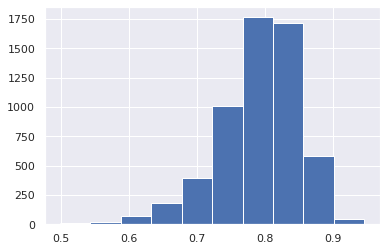

In [173]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)

matplotlib.pyplot.hist(weights)

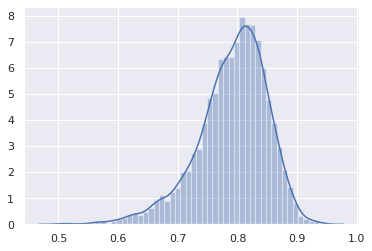

In [174]:
x = weights
sns.distplot(x);

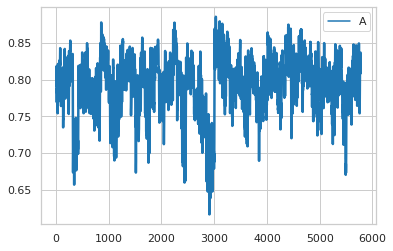

In [175]:
sns.set(style="whitegrid")

rs = np.random.RandomState(365)
values = weights
dates = list(range(len(weights)))
data = pd.DataFrame(values, dates, columns=["A"])
data = data.rolling(7).mean()

sns.lineplot(data=data, palette="tab10", linewidth=2.5)

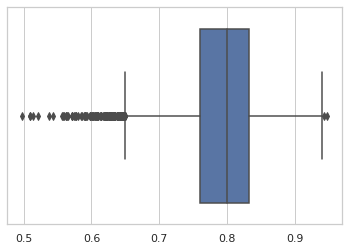

In [176]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(x=weights)

In [150]:
max(weights)

0.9462240769071713

In [188]:
q3 = np.percentile(weights, 75)
iqr = np.subtract(*np.percentile(weights, [75, 25]))
outlier = q3 + 1.5 * iqr

In [189]:
outlier

0.9169348297982355

In [190]:
q1 = np.percentile(weights, 25)
iqr = np.subtract(*np.percentile(weights, [75, 25]))
outlier = q1 - 1.5 * iqr

In [191]:
outlier

0.46913903730425377

In [195]:
outlier = q3

In [196]:
outlier_removed = []
for item in weights:
    if item <=outlier:
        outlier_removed.append(item)

In [197]:
len(outlier_removed) -len(weights)

-1445

In [198]:
len(weights)

5778

In [56]:
a = compute_feature_vector_gpt([["I do not remember ever having to do a schema change."]], lambda_function)
b = compute_feature_vector_gpt([["It would be the same as if you were to alter the scheme over here for the database."]], lambda_function)
cosine(a[0][0], b[0][0])

{"level": "info", "filename": "<ipython-input-13-76e96698eb24>", "lineno": 39, "module": "<ipython-input-13-76e96698eb24>", "batches count": 1, "number of sentences": 1, "ts": "2019-10-19T02:28:20.464159Z", "msg": "computing in batches"}
{"level": "info", "filename": "<ipython-input-13-76e96698eb24>", "lineno": 44, "module": "<ipython-input-13-76e96698eb24>", "iteration count:": 0, "ts": "2019-10-19T02:28:20.464927Z", "msg": "getting feature vector from mind service"}
{"level": "debug", "filename": "hooks.py", "lineno": 210, "module": "hooks", "ts": "2019-10-19T02:28:20.465565Z", "msg": "Event before-parameter-build.lambda.Invoke: calling handler <function generate_idempotent_uuid at 0x7fcb5ae61b70>"}
{"level": "debug", "filename": "hooks.py", "lineno": 210, "module": "hooks", "ts": "2019-10-19T02:28:20.465987Z", "msg": "Event before-call.lambda.Invoke: calling handler <function inject_api_version_header_if_needed at 0x7fcb5ade7598>"}
{"level": "debug", "filename": "endpoint.py", "line

{"level": "debug", "filename": "hooks.py", "lineno": 210, "module": "hooks", "ts": "2019-10-19T02:28:20.952935Z", "msg": "Event choose-signer.lambda.Invoke: calling handler <function set_operation_specific_signer at 0x7fcb5ae61a60>"}
{"level": "debug", "filename": "auth.py", "lineno": 364, "module": "auth", "ts": "2019-10-19T02:28:20.953395Z", "msg": "Calculating signature using v4 auth."}
{"level": "debug", "filename": "auth.py", "lineno": 365, "module": "auth", "ts": "2019-10-19T02:28:20.953709Z", "msg": "CanonicalRequest:\nPOST\n/2015-03-31/functions/mind-01daayheky5f4e02qvrjptftxv/invocations\n\nhost:lambda.us-east-1.amazonaws.com\nx-amz-date:20191019T022820Z\nx-amz-invocation-type:RequestResponse\n\nhost;x-amz-date;x-amz-invocation-type\n802c367358116189a32903b1526cb9a02a59c87fa91ceea50f32f66ef03689fb"}
{"level": "debug", "filename": "auth.py", "lineno": 367, "module": "auth", "ts": "2019-10-19T02:28:20.954032Z", "msg": "StringToSign:\nAWS4-HMAC-SHA256\n20191019T022820Z\n20191019/

0.8228246770677313

# keyword comparison

In [51]:
comparison_list = []
for nodea, nodeb, weight in original_graph.edges.data():
    comparison_list.append((nodea, nodeb, weight["weight"]))

comparison_list = sorted(comparison_list, key=lambda kv:kv[-1], reverse=True)
for a,b,distance in comparison_list:
    print ("--------sent--------\n\n", graph_list[a],"\n\n", graph_list[b], "\n", distance, "\n", segtocls[a], "=>", segtocls[b],"\n\n\n\n")

--------sent--------

 So let us dig into that a little bit. 

 Let is take a look at it. 
 0.9553863484644594 
 1 => 1 




--------sent--------

 Right, so we cannot we just started to figure that out. 

 So like what should we do about that? 
 0.9447276795181943 
 8 => 8 




--------sent--------

 Alright, we will take this off for you. 

 Okay, so we will take that up as a backlog item. 
 0.9401306334887837 
 1 => 4 




--------sent--------

 So even that yeah, so I discussed this bit. 

 So I just took the I just want to be really yeah, it is offline. 
 0.9393572591086908 
 17 => 17 




--------sent--------

 So if you look at the schema structure, so we got an idea. 

 So you can just directly take whatever graph we have and we can populate it but indeed in the in case of D graph we have to set initial schema. 
 0.9333535132353137 
 0 => 0 




--------sent--------

 It became need to see if we need to prioritize this over that let us prioritize what we discussed which is you 

 0.8733829893259717 
 1 => 3 




--------sent--------

 So we replace that there are some policies. 

 So that is the tradeoff if we are operating on teams. 
 0.8733713570337718 
 10 => 8 




--------sent--------

 It became need to see if we need to prioritize this over that let us prioritize what we discussed which is you know, like you it is all of these things right? 

 You know if there is a convinced I am good with it, but just keep that in the back of your mind. 
 0.8733478644774466 
 9 => 9 




--------sent--------

 Okay, see the real the world really want to know kind of what I am trying to say is when we take up some task.Let is make sure it gets all the way to production before we get to something else right unless it is an experimental investigative thing to just develop the discipline that we stick with something and see through the production right so we do not give a reason okay. 

 I mean meeting it is to uuids now. 
 0.873193487254924 
 9 => 16 




--------sent---

 Alright, we will take this off for you. 

 we can check when you are loading the asset side. 
 0.8593602376600696 
 1 => 1 




--------sent--------

 Right, so we cannot we just started to figure that out. 

 So what we will do see the plan of action is if the SDK gets integrated if we are able to test in staging and everything works. 
 0.8593584325499378 
 8 => 0 




--------sent--------

 We can make it zero to be minimum instead of like showing that negative value. 

 So what we will do see the plan of action is if the SDK gets integrated if we are able to test in staging and everything works. 
 0.8593366892261269 
 4 => 0 




--------sent--------

 I mean they did not change.Okay, so in staging the changes are yeah, they changed I am not sure whether you have whether the board was reinvited. 

 So I just took the I just want to be really yeah, it is offline. 
 0.8593224721542161 
 16 => 17 




--------sent--------

 Thus the top few ones and if next whenever we add new relatio

 There is no restrictions because no it is not necessary really hard even sequence for generally rdbms schema means different because we try to say this is of this type and we are here in force types and trying to Signal this carbonyl Etc. 

 Let is see how it goes through and then otherwise, I am working on the summary service like basic coding is done. 
 0.8499781905145278 
 0 => 1 




--------sent--------

 No, I think it has nothing to do with it the left side if this offline so we have Google transcripts for Collins call. 

 Also connects to the city and cash thing, right? 
 0.849977729737346 
 18 => 18 




--------sent--------

 All the other types are not the same because they support decent marshalling and marshaling right? 

 Or that we already have the kind of conditions climb said other things. 
 0.8499663077771601 
 8 => 8 




--------sent--------

 Let is see how it goes through and then otherwise, I am working on the summary service like basic coding is done. 

 So lik

 3 => 10 




--------sent--------

 And I think that is all that is needed right now. 

 Let is see how it goes through and then otherwise, I am working on the summary service like basic coding is done. 
 0.8428196266100173 
 8 => 1 




--------sent--------

 I mean some of these things can come back and bite us once you have you know, like a big graph is head is the glass used in production mirror. 

 So the CIA, you know we shall again just to reiterate the goal is that if you want to show some output from the graph.We should kind of determine one inside and just walk backwards as a goal either so that we have something to show that this is, you know coming from the graphs and so on and so forth, you know.Yeah, so for that like so like other databases like neoXnumberXj or Neptune and all this thing up up. 
 0.8428139615817538 
 8 => 16 




--------sent--------

 Okay, did we resolve that issue of the first time stamp being incorrect in the full transcript? 

 So it is showing up i

 Make some things should fall fall back into place.Because we cannot read meeting entry and guarding enter and other things so. 
 0.836171544955496 
 16 => 9 




--------sent--------

 I mean so, you know, so once metal is done with the caching.Your is going to pick up the payment cycle or work with Shawshank on the graph platform related issues. 

 Okay you and they will continue to work on chime and like maybe if you have bandwidth start to look at the top boxes. 
 0.8361505408143679 
 18 => 18 




--------sent--------

 So one other question is on the grass. 

 And I think that is all that is needed right now. 
 0.8361452851509243 
 8 => 8 




--------sent--------

 So that is why I am saying it is not it is not a relation counter and say. 

 Yeah, I use the default one the least aggressive one just to start with.He is comparing the body segmentation process with the one that we have in ceiling in production as opposed to when we used tool with the bodies of the XnumberXs the voi

 18 => 16 




--------sent--------

 And once the the video is finished. 

 So when you invited the clothes and we invite either to a new workspace and we do demo calls, right? 
 0.8306738950178139 
 8 => 9 




--------sent--------

 So that is why I am saying it is not it is not a relation counter and say. 

 Very approach where it says I do not care. 
 0.8306631274181401 
 17 => 9 




--------sent--------

 Or that we already have the kind of conditions climb said other things. 

 Right like the Golden Test validation said if you give him then we can have do that. 
 0.8306561787518578 
 8 => 4 




--------sent--------

 You have to break our primary database and make a data table schema cell phones representation of data now does not really need to make sure variable in graph terminology. 

 keep in mind a graph lingo is basically like giving an overview representation of what the nodes and the relation look like. 
 0.8306521858784858 
 0 => 6 




--------sent--------

 Like reg

 18 => 9 




--------sent--------

 Like registered like like completed but invitation process yesterday. 

 No, let us let warning finish the making the full transcripts clickable and liked one of your comment. 
 0.8258020804000349 
 18 => 9 




--------sent--------

 Sorry, but it is a even when we do Play Back in the Netflix mode. 

 But also the you know, yeah, so right now we have everything from like at least in production, which is populated in Neptune. 
 0.8258019661643273 
 4 => 16 




--------sent--------

 No, let us let warning finish the making the full transcripts clickable and liked one of your comment. 

 I mean they did not change.Okay, so in staging the changes are yeah, they changed I am not sure whether you have whether the board was reinvited. 
 0.8257867761602893 
 9 => 16 




--------sent--------

 I mean meeting it is to uuids now. 

 Sorry, but it is a even when we do Play Back in the Netflix mode. 
 0.8257795426099501 
 16 => 4 




--------sent--------

 

 They do not need us to set a defined schema beforehand. 
 0.8209230328132033 
 8 => 10 




--------sent--------

 So like what should we do about that? 

 So all it needs to do is read the MPXnumberX URL from the meeting info. 
 0.8209124464460688 
 8 => 0 




--------sent--------

 So we finished implementation and it is a product ssion and sometimes we are seeing the timestamp to be incorrect right for the transcripts is that the problem alone like for example, if for whatever reason in your calculation it shows up as night like we sure you shot one example is today, right?. 

 Sorry, but it is a even when we do Play Back in the Netflix mode. 
 0.8209007293874551 
 16 => 4 




--------sent--------

 Sorry, but it is a even when we do Play Back in the Netflix mode. 

 I mean they did not change.Okay, so in staging the changes are yeah, they changed I am not sure whether you have whether the board was reinvited. 
 0.8208967503461492 
 4 => 16 




--------sent--------

 It is this 

 0 => 3 




--------sent--------

 So once Karthik deploys his changes we can do one rough end to end testing by hardcoding someone video like a podcast or something see how the transcription of the cancer comes. 

 There will be there will not be a service provider per se right.Because playback ok, so it is like you can use that for other conditions. 
 0.8165350312785665 
 4 => 3 




--------sent--------

 So after this I will start so there are few like small things remaining like active icon for the screen share and maybe I did. 

 And once the the video is finished. 
 0.8165318019878248 
 18 => 8 




--------sent--------

 If you want to change it you should be able to change the schema and apply somewhere.Yeah, okay. 

 You know if there is a convinced I am good with it, but just keep that in the back of your mind. 
 0.8165311285773332 
 16 => 9 




--------sent--------

 No, I think it has nothing to do with it the left side if this offline so we have Google transcripts for C

 8 => 4 




--------sent--------

 Because if I if I use webrtc vad I got XnumberX action items were. 

 Like registered like like completed but invitation process yesterday. 
 0.8124165155106088 
 17 => 18 




--------sent--------

 Yeah, it is an interlocked with leukemia. 

 I mean they did not change.Okay, so in staging the changes are yeah, they changed I am not sure whether you have whether the board was reinvited. 
 0.8124135955058377 
 16 => 16 




--------sent--------

 Yeah, yes, I so we are like we discussed I discussed this money. 

 Like registered like like completed but invitation process yesterday. 
 0.8124024155011659 
 16 => 18 




--------sent--------

 So even that yeah, so I discussed this bit. 

 Yeah, we can we can move it. 
 0.812389972924193 
 17 => 16 




--------sent--------

 No, I think it has nothing to do with it the left side if this offline so we have Google transcripts for Collins call. 

 So webrtc really does not clean better job but single user

 Okay, so sometimes it is actually on for the transcripts of set be captured in the front. 

 So if this testing is an ether love that means is using child.No, actually we have created four columns call it. 
 0.808218978651731 
 3 => 0 




--------sent--------

 So I was just testing that so after this meeting I will deploy to staging to one test at this verse Okay, so yesterday so couple of things I would exiting staging you guys are seeing some panic and all that.Is that there is a slated to this, okay?. 

 The only thing we are trying to see is there is there is possibly a partner Summit that the stock box guys have end of October that you know, initially we told them that we will not be able to do it because they do not give lost and then all that right? 
 0.8082118648058506 
 16 => 9 




--------sent--------

 All the other types are not the same because they support decent marshalling and marshaling right? 

 So once Karthik deploys his changes we can do one rough end to end te

 I mean some of these things can come back and bite us once you have you know, like a big graph is head is the glass used in production mirror. 

 So even that yeah, so I discussed this bit. 
 0.8039702610132019 
 8 => 17 




--------sent--------

 Let is see how it goes through and then otherwise, I am working on the summary service like basic coding is done. 

 Because it is just the Lander services that need to be removed. 
 0.8039692618694735 
 1 => 15 




--------sent--------

 All one word is always coming wrong EXO feel sort of SFU. 

 What what how I have been testing is I just read out some random or or this.Text from the document and then explicitly insert some action items and I am just ask XnumberX to do the same things. 
 0.8039617417192969 
 18 => 17 




--------sent--------

 I am not yet showing the time I am showing the text and also, yeah, I will work on it. 

 We can make it zero to be minimum instead of like showing that negative value. 
 0.8039350296422757 
 17 

 0.8001008375743602 
 18 => 16 




--------sent--------

 If you want to speaker info, so we need to handle some formatting related things, you know. 

 An example of a schema change leader of like what is it like it just in general for girls like what what?. 
 0.800090522552994 
 3 => 10 




--------sent--------

 And one thing I have observed is just posted an MLA. 

 Like registered like like completed but invitation process yesterday. 
 0.800090474091389 
 17 => 18 




--------sent--------

 You have to break our primary database and make a data table schema cell phones representation of data now does not really need to make sure variable in graph terminology. 

 But also the you know, yeah, so right now we have everything from like at least in production, which is populated in Neptune. 
 0.8000867577053004 
 0 => 16 




--------sent--------

 They need to know because everybody uses really way to query the through recipes Etc. 

 So the CIA, you know we shall again just to rei

 8 => 9 




--------sent--------

 And then we use QuickTime or some other way to construct a custom playlist. 

 An example of a schema change leader of like what is it like it just in general for girls like what what?. 
 0.7962607479031385 
 4 => 10 




--------sent--------

 I will just deployed deployed then I start to pick the Gypsy and calls you. 

 It is just we need to remap in the production. 
 0.7962373956573539 
 18 => 4 




--------sent--------

 All the other types are not the same because they support decent marshalling and marshaling right? 

 We set it to level bonding than errors. 
 0.7962314320931203 
 8 => 4 




--------sent--------

 Alright, we will take this off for you. 

 Like should we like should deem work on that part?. 
 0.7962253107445045 
 1 => 10 




--------sent--------

 It is this small change article as I change it. 

 Oh, no, no just like watch Lingus part is done. 
 0.7962138013508742 
 1 => 16 




--------sent--------

 All the other types ar

 0.7927619751084302 
 1 => 15 




--------sent--------

 It became need to see if we need to prioritize this over that let us prioritize what we discussed which is you know, like you it is all of these things right? 

 Were in for whatever reason we decided to calculate it in Franklin and we went ahead as implementation. 
 0.792752471957674 
 9 => 13 




--------sent--------

 So it seems like a different provider where it does not support like all Rowling has is video recorded video. 

 So he will be sharing in next few minutes. 
 0.7927435152319358 
 3 => 10 




--------sent--------

 Were in for whatever reason we decided to calculate it in Franklin and we went ahead as implementation. 

 For example today we have something like to today is structure of graph will have context instance ID. 
 0.7927422870083878 
 13 => 0 




--------sent--------

 So what you have to do is that by the time the quarter started someone was already speaking. 

 Yesterday, so he said that they will h

KeyError: 160

In [30]:
temp = []
for nodea, nodeb, weight in meeting_graph_pruned.edges.data():
    temp.append(nodea)
    temp.append(nodeb)
    
sorted(temp)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,


In [31]:
from collections import Counter

for (nodea, count ) in Counter(temp).most_common()[:4]:
    print (graph_list[nodea])

It became need to see if we need to prioritize this over that let us prioritize what we discussed which is you know, like you it is all of these things right?
Now in this case, I do not see you.
So that is what it is also generating errors.
So we did not we realize a little late on the so after that I think after that the summaries are coming up.


In [32]:
Counter(temp).most_common()

[(19, 142),
 (136, 141),
 (75, 127),
 (45, 124),
 (87, 124),
 (40, 122),
 (23, 119),
 (164, 119),
 (70, 118),
 (33, 117),
 (122, 116),
 (125, 116),
 (0, 107),
 (39, 107),
 (56, 107),
 (79, 107),
 (165, 107),
 (118, 106),
 (127, 105),
 (92, 104),
 (13, 103),
 (102, 103),
 (30, 102),
 (25, 101),
 (54, 98),
 (6, 97),
 (149, 97),
 (94, 94),
 (185, 94),
 (78, 93),
 (100, 93),
 (195, 93),
 (18, 91),
 (32, 91),
 (137, 91),
 (142, 91),
 (58, 90),
 (3, 89),
 (64, 88),
 (28, 86),
 (60, 86),
 (69, 86),
 (184, 86),
 (119, 82),
 (155, 82),
 (114, 81),
 (2, 80),
 (89, 80),
 (151, 80),
 (52, 78),
 (130, 77),
 (171, 77),
 (179, 77),
 (42, 76),
 (65, 75),
 (189, 75),
 (27, 73),
 (74, 71),
 (140, 71),
 (150, 71),
 (170, 71),
 (192, 71),
 (26, 71),
 (158, 71),
 (196, 70),
 (138, 69),
 (186, 69),
 (82, 68),
 (152, 66),
 (200, 66),
 (177, 66),
 (41, 65),
 (143, 65),
 (61, 64),
 (4, 63),
 (168, 63),
 (135, 62),
 (201, 62),
 (63, 61),
 (117, 61),
 (197, 61),
 (176, 59),
 (35, 59),
 (11, 58),
 (126, 57),
 (13

In [33]:
community_set_sorted

[(0, 0),
 (3, 0),
 (6, 0),
 (9, 0),
 (10, 0),
 (13, 0),
 (20, 0),
 (30, 0),
 (32, 0),
 (37, 0),
 (40, 0),
 (42, 0),
 (48, 0),
 (49, 0),
 (51, 0),
 (55, 0),
 (56, 0),
 (57, 0),
 (58, 0),
 (59, 0),
 (60, 0),
 (61, 0),
 (62, 0),
 (63, 0),
 (65, 0),
 (72, 0),
 (73, 0),
 (75, 0),
 (77, 0),
 (78, 0),
 (81, 0),
 (88, 0),
 (94, 0),
 (97, 0),
 (100, 0),
 (104, 0),
 (106, 0),
 (107, 0),
 (108, 0),
 (119, 0),
 (120, 0),
 (130, 0),
 (135, 0),
 (137, 0),
 (138, 0),
 (140, 0),
 (142, 0),
 (150, 0),
 (165, 0),
 (173, 0),
 (176, 0),
 (179, 0),
 (180, 0),
 (184, 0),
 (185, 0),
 (189, 0),
 (194, 0),
 (195, 0),
 (196, 0),
 (198, 0),
 (199, 0),
 (1, 1),
 (4, 1),
 (5, 1),
 (11, 1),
 (12, 1),
 (14, 1),
 (19, 1),
 (21, 1),
 (23, 1),
 (33, 1),
 (34, 1),
 (36, 1),
 (39, 1),
 (41, 1),
 (53, 1),
 (64, 1),
 (68, 1),
 (70, 1),
 (74, 1),
 (76, 1),
 (79, 1),
 (82, 1),
 (91, 1),
 (95, 1),
 (98, 1),
 (102, 1),
 (111, 1),
 (112, 1),
 (121, 1),
 (124, 1),
 (125, 1),
 (126, 1),
 (127, 1),
 (132, 1),
 (139, 1),
 (141, 1),

In [1]:
import spacy
from benepar.spacy_plugin import BeneparComponent
import benepar

benepar.download('benepar_en')
nlp = spacy.load('en')

nlp.add_pipe(BeneparComponent('benepar_en'))
doc = nlp("The time for action is now. It's never too late to do something.")
sent = list(doc.sents)[0]
print(sent._.parse_string)
# (S (NP (NP (DT The) (NN time)) (PP (IN for) (NP (NN action)))) (VP (VBZ is) (ADVP (RB now))) (. .))
print(sent._.labels)
# ('S',)
print(list(sent._.children)[0])
# The time for action

[nltk_data] Downloading package benepar_en to /home/ray__/nltk_data...
[nltk_data]   Package benepar_en is already up-to-date!



(S (NP (NP (DT The) (NN time)) (PP (IN for) (NP (NN action)))) (VP (VBZ is) (ADVP (RB now))) (. .))
('S',)
The time for action


In [4]:
doc = nlp("AWS transcribe machine is working good in staging2.")
sent = list(doc.sents)[0]
print(sent._.parse_string)
# (S (NP (NP (DT The) (NN time)) (PP (IN for) (NP (NN action)))) (VP (VBZ is) (ADVP (RB now))) (. .))
print(sent._.labels)
# ('S',)
print(list(sent._.children)[0])
# The time for action

(S (NP (NN AWS) (NN transcribe) (NN machine)) (VP (VBZ is) (VP (VBG working) (ADJP (JJ good)) (PP (IN in) (NP (NN staging2))))) (. .))
('S',)
AWS transcribe machine


In [8]:
doc = nlp("Maybe it four times at least he did send a signal.")
sent = list(doc.sents)[0]
print(sent._.parse_string)
# (S (NP (NP (DT The) (NN time)) (PP (IN for) (NP (NN action)))) (VP (VBZ is) (ADVP (RB now))) (. .))
print(sent._.labels)
# ('S',)
print(list(sent._.children)[0])
# The time for action


(S (ADVP (RB Maybe)) (NP (PRP it)) (NP (NP (CD four) (NNS times)) (IN at) (JJS least)) (NP (PRP he)) (VP (VBD did) (VP (VB send) (NP (DT a) (NN signal)))) (. .))
('S',)
Maybe


In [17]:
doc = nlp("I started seeing the code Recorder Server code on and we probably like by today I'll start working on that issue let.")
sent = list(doc.sents)[0]
print(sent._.parse_string)

(S (NP (PRP I)) (VP (VBD started) (S (VP (VBG seeing) (NP (DT the) (NN code) (NNP Recorder) (NNP Server) (VB code)) (PP (RP on))))))


In [10]:
doc = nlp("You just need to be careful of when we decide to trigger an end call ourselves.")
sent = list(doc.sents)[0]
print(sent._.parse_string)

(S (NP (PRP You)) (ADVP (RB just)) (VP (VBP need) (S (VP (TO to) (VP (VB be) (ADJP (JJ careful) (PP (IN of) (SBAR (WHADVP (WRB when)) (S (NP (PRP we)) (VP (VBP decide) (S (VP (TO to) (VP (VB trigger) (NP (DT an) (NN end) (VB call)) (NP (PRP ourselves)))))))))))))) (. .))


In [11]:
doc = nlp("Then why don't you talk about the websocket?.")
sent = list(doc.sents)[0]
print(sent._.parse_string)

(SBARQ (RB Then) (WHADVP (WRB why)) (SQ (VBP do) (RB n't) (NP (PRP you)) (VP (VB talk) (PP (IN about) (NP (DT the) (NN websocket))))) (. ?) (. .))


In [18]:
doc = nlp("We can not appear or you can follow the path.")
sent = list(doc.sents)[0]
print(sent._.parse_string)

(S (S (NP (PRP We)) (VP (MD can) (RB not) (VP (VB appear)))) (CC or) (S (NP (PRP you)) (VP (MD can) (VP (VB follow) (NP (DT the) (NN path))))) (. .))


In [13]:
doc = nlp("You know can you and we may take a look at this?")
sent = list(doc.sents)[0]
print(sent._.parse_string)

(S (S (NP (PRP You)) (VP (VBP know) (MD can) (NP (PRP you)))) (CC and) (S (NP (PRP we)) (VP (MD may) (VP (VB take) (NP (DT a) (NN look)) (PP (IN at) (NP (DT this)))))) (. ?))


In [19]:
doc = nlp("Same work is not a new industry usually frameworks aren't designed with the visa that from white of old for common functionality in industry.")
sent = list(doc.sents)[0]
print(sent._.parse_string)

(S (NP (NP (JJ Same) (NN work)) (VP (VBZ is) (RB not) (NP (DT a) (JJ new) (NN industry)))) (ADVP (RB usually)) (NP (NNS frameworks)) (VP (VBP are) (RB n't) (VP (VBN designed) (PP (IN with) (NP (NP (NP (DT the) (NN visa)) (IN that)) (PP (IN from) (ADJP (NP (JJ white)) (PP (IN of) (ADJP (JJ old))))) (PP (IN for) (NP (NP (JJ common) (NN functionality)) (PP (IN in) (NP (NN industry))))))))) (. .))


In [21]:
mg, yet_to_prune = construct_graph(fv,graph_list)

In [53]:
norm_mat = nx.normalized_laplacian_matrix(mg).toarray()

In [55]:
new_mg = nx.from_numpy_array(norm_mat)

In [118]:
arr = np.array([[0.9,0.65,0.65,0.4],[0.9,0.6,0.6,0.4],[0.7,0.65,0.6,0.4],[0.7,0.65,0.6,0.4]])


In [138]:
mtarr = adj_mat.toarray()
mtarr

array([[0.        , 0.86517928, 0.79468135, 0.90994716, 0.89767715,
        0.75681371, 0.49069862, 0.43744629, 0.34147844, 0.94940729,
        0.69106767, 0.89752731, 0.89252983, 0.66401061, 0.57476074,
        0.69342702, 0.58086929, 0.6457705 , 0.64452582, 0.65764377,
        0.64452582, 0.65764377, 0.7153621 , 0.65412001, 0.67008085,
        0.64184137, 0.62101658, 0.57281366, 0.59527963, 0.66290501],
       [0.86517928, 0.        , 0.86853956, 0.78433505, 0.8684492 ,
        0.79819835, 0.54290261, 0.46251866, 0.409625  , 0.80386353,
        0.73676003, 0.88635761, 0.8213386 , 0.73170683, 0.68747473,
        0.66956396, 0.60217701, 0.71526848, 0.71926691, 0.73628039,
        0.71926691, 0.73628039, 0.77036271, 0.73674962, 0.70340663,
        0.72451182, 0.71306235, 0.66079314, 0.65625295, 0.67324536],
       [0.79468135, 0.86853956, 0.        , 0.68063203, 0.84515773,
        0.71734709, 0.52463841, 0.48150323, 0.4098757 , 0.76179279,
        0.68084113, 0.87093928, 0.80276547, 0.

In [183]:
coms = nx.algorithms.community.label_propagation.label_propagation_communities(mg)

In [184]:
for com in coms:
    print(com)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}


In [152]:
mg.edges.data()

EdgeDataView([(0, 1, {'weight': 0.8651792770213481}), (0, 2, {'weight': 0.7946813537519716}), (0, 3, {'weight': 0.9099471607978834}), (0, 4, {'weight': 0.8976771458160738}), (0, 5, {'weight': 0.7568137128144239}), (0, 6, {'weight': 0.4906986211200429}), (0, 7, {'weight': 0.43744628860166884}), (0, 8, {'weight': 0.34147844065294175}), (0, 9, {'weight': 0.9494072936956971}), (0, 10, {'weight': 0.69106767277158}), (0, 11, {'weight': 0.8975273103758501}), (0, 12, {'weight': 0.892529830750924}), (0, 13, {'weight': 0.6640106117563596}), (0, 14, {'weight': 0.5747607357040782}), (0, 15, {'weight': 0.6934270185454394}), (0, 16, {'weight': 0.5808692868480433}), (0, 17, {'weight': 0.6457705045291043}), (0, 18, {'weight': 0.644525822060585}), (0, 19, {'weight': 0.6576437718170873}), (0, 20, {'weight': 0.644525822060585}), (0, 21, {'weight': 0.6576437718170873}), (0, 22, {'weight': 0.7153621034472333}), (0, 23, {'weight': 0.654120008595783}), (0, 24, {'weight': 0.6700808519867759}), (0, 25, {'weigh

In [206]:
tg = nx.Graph()
tg.add_nodes_from([1,2,3,4])

In [207]:
tg.edges.data()

EdgeDataView([])

In [208]:
tg.add_edge(1,2, weight=1)
tg.add_edge(2,3, weight=10)
#tg.add_edge(1,3, weight=10)

In [235]:
coms = list(nx.algorithms.community.girvan_newman(meeting_graph_pruned))

In [236]:
for com in list(coms):
    for di in com:
        for sent in list(di):
            print (graph_list[sent])
        print ("\n --------------> \n")
    break

Docker is a tool designed to make it easier to create, deploy, and run applications by using containers.
Containers allow a developer to package up an application with all of the parts it needs, such as libraries and other dependencies, and ship it all out as one package.
By doing so, thanks to the container, the developer can rest assured that the application will run on any other Linux machine regardless of any customized settings that machine might have that could differ from the machine used for writing and testing the code.
In a way, Docker is a bit like a virtual machine.
But unlike a virtual machine, rather than creating a whole virtual operating system, Docker allows applications to use the same Linux kernel as the system that they are running on and only requires applications be shipped with things not already running on the host computer.
This gives a significant performance boost and reduces the size of the application.
The earth is climate has changed throughout history jus

In [310]:
X = nx.adjacency_matrix(mg,).toarray()
for i in range(len(X)):
    X[i][i]=X[i].mean() 
X_std= (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (X.max() - X.min()) + X.min()

In [311]:
X_scaled

array([[0.6872679 , 0.97074589, 0.89108337, 1.        , 0.98589288,
        0.89285073, 0.34147844, 0.34147844, 0.34147844, 1.        ,
        0.8689225 , 0.98687661, 1.        , 0.67295513, 0.55960817,
        0.79225861, 0.68326229, 0.75475573, 0.56456354, 0.5953119 ,
        0.56456354, 0.5953119 , 0.76162795, 0.69107806, 0.67481823,
        0.71870207, 0.60192486, 0.49204507, 0.52789079, 0.82579332],
       [0.90876241, 0.73354329, 0.99657256, 0.84022506, 0.94490031,
        1.        , 0.44336007, 0.40707432, 0.43369335, 0.82935409,
        0.96604661, 0.97251727, 0.90517154, 0.79660666, 0.77018774,
        0.75348429, 0.73673279, 0.88591408, 0.65611729, 0.68826568,
        0.65611729, 0.68826568, 0.85112782, 0.83535747, 0.73132868,
        0.91082607, 0.80516077, 0.63675292, 0.62841467, 0.84681814],
       [0.83239755, 0.97538753, 0.72763454, 0.70831785, 0.91223371,
        0.79066741, 0.40771553, 0.45674292, 0.43403258, 0.78002734,
        0.84718486, 0.95269605, 0.88043166, 0.

In [312]:
X_std

array([[5.25099683e-01, 9.55576072e-01, 8.34604312e-01, 1.00000000e+00,
        9.78577592e-01, 8.37288134e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 8.00951843e-01, 9.80071434e-01,
        1.00000000e+00, 5.03364973e-01, 3.31241591e-01, 6.84533657e-01,
        5.19016940e-01, 6.27583530e-01, 3.38766585e-01, 3.85459603e-01,
        3.38766585e-01, 3.85459603e-01, 6.38019363e-01, 5.30885604e-01,
        5.06194197e-01, 5.72834140e-01, 3.95501733e-01, 2.28643437e-01,
        2.83077064e-01, 7.35457887e-01],
       [8.61450865e-01, 5.95371315e-01, 9.94795253e-01, 7.57373262e-01,
        9.16328187e-01, 1.00000000e+00, 1.54712663e-01, 9.96108271e-02,
        1.40033238e-01, 7.40865106e-01, 9.48439972e-01, 9.58266014e-01,
        8.55997936e-01, 6.91136393e-01, 6.51017871e-01, 6.25652793e-01,
        6.00214739e-01, 8.26754459e-01, 4.77795826e-01, 5.26614859e-01,
        4.77795826e-01, 5.26614859e-01, 7.73929672e-01, 7.49981558e-01,
        5.92008313e-01,